In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages
from IPython.display import Image, display

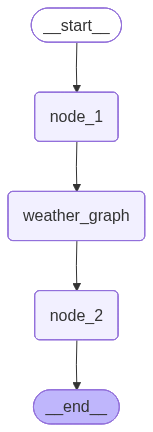

Testing the graph with San Francisco weather query

Output from node 'node_1':
Messages: [AIMessage(content='Processing your request...', additional_kwargs={}, response_metadata={}, id='4e719f50-9e7b-4169-b917-b8a5a315e017')]
------------------------------------------------------------

Output from node 'weather_graph':
Messages: [HumanMessage(content="What's the weather in San Francisco?", additional_kwargs={}, response_metadata={}, id='58b8d5f2-25fb-41de-a124-7a5f91dd1f14'), AIMessage(content='Processing your request...', additional_kwargs={}, response_metadata={}, id='4e719f50-9e7b-4169-b917-b8a5a315e017'), AIMessage(content="It's 32 degrees and sunny.", additional_kwargs={}, response_metadata={}, id='6f8f1ab8-c326-4dd6-adaf-3b3ca12bc7f7'), AIMessage(content="Weather analysis: Based on the data, It's 32 degrees and sunny.", additional_kwargs={}, response_metadata={}, id='08c194d5-a350-456d-91b3-19559d20003a')]
------------------------------------------------------------

Output from

In [ ]:
# Define states
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

class SubgraphState(TypedDict):
    messages: Annotated[list, add_messages]

# ========== Create Subgraph (Weather Graph) ==========
subgraph_builder = StateGraph(SubgraphState)

def check_weather(state: SubgraphState):
    """Simulates checking weather"""
    last_message = state["messages"][-1]
    query = last_message.content

    if "san francisco" in query.lower() or "sf" in query.lower():
        weather_info = "It's 16 degrees and foggy in San Francisco."
    else:
        weather_info = "It's 32 degrees and sunny."

    return {"messages": [AIMessage(content=weather_info)]}

def analyze_weather(state: SubgraphState):
    """Analyzes the weather information"""
    last_message = state["messages"][-1]
    analysis = f"Weather analysis: Based on the data, {last_message.content}"
    return {"messages": [AIMessage(content=analysis)]}

# Add nodes to subgraph
subgraph_builder.add_node("check_weather", check_weather)
subgraph_builder.add_node("analyze_weather", analyze_weather)

# Define subgraph flow
subgraph_builder.add_edge(START, "check_weather")
subgraph_builder.add_edge("check_weather", "analyze_weather")
subgraph_builder.add_edge("analyze_weather", END)

# Compile subgraph
subgraph = subgraph_builder.compile()

# ========== Create Parent Graph ==========
builder = StateGraph(ParentState)

def node_1(state: ParentState):
    """First node that processes initial request"""
    return {"messages": [AIMessage(content="Processing your request...")]}

def node_2(state: ParentState):
    """Node after subgraph"""
    return {"messages": [AIMessage(content="Request completed successfully!")]}

# Add nodes to parent graph
builder.add_node("node_1", node_1)
builder.add_node("weather_graph", subgraph)  # Add subgraph as a node
builder.add_node("node_2", node_2)

# Define parent graph flow
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "weather_graph")
builder.add_edge("weather_graph", "node_2")
builder.add_edge("node_2", END)

# Compile parent graph
graph = builder.compile()

# Display the graph structure
display(Image(graph.get_graph().draw_mermaid_png()))

# ========== Test the Graph ==========
print("=" * 60)
print("Testing the graph with San Francisco weather query")
print("=" * 60)

inputs = {
    "messages": [HumanMessage(content="What's the weather in San Francisco?")]
}

for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"\nOutput from node '{key}':")
        print(f"Messages: {value['messages']}")
        print("-" * 60)

# Show final state
print("\n" + "=" * 60)
print("Final conversation:")
print("=" * 60)
final_state = graph.invoke(inputs)
for msg in final_state["messages"]:
    print(f"{msg.__class__.__name__}: {msg.content}")